<a href="https://colab.research.google.com/github/kridtapon/TrendPower-HMA-ADX-/blob/main/TrendPower_(HMA%2BADX).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.4/527.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninst

[*********************100%***********************]  1 of 1 completed
<ipython-input-1-6d95eadda64c>:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'final_value': portfolio.value()[-1]
<ipython-input-1-6d95eadda64c>:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'final_value': portfolio.value()[-1]


Best Parameters:
hma_window            3.000000
period               23.000000
adx_threshold        36.000000
final_value      243112.823633
Name: 4135, dtype: float64


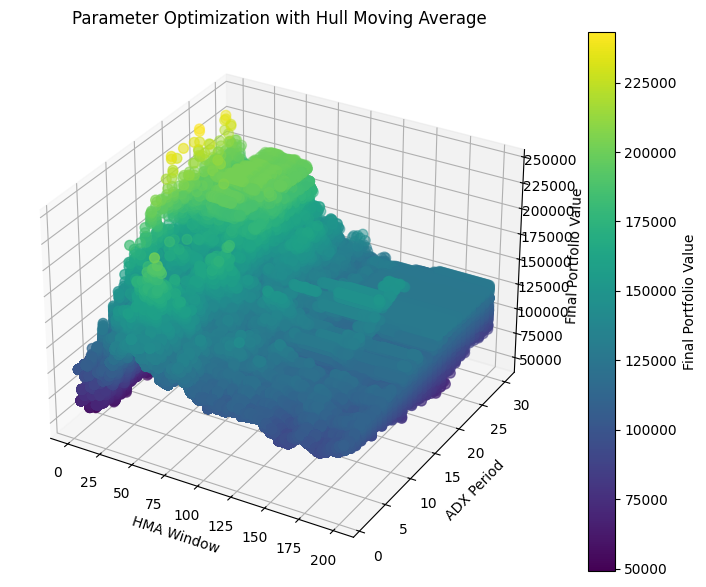

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Calculate Weighted Moving Average (WMA)
def calculate_wma(df, window):
    """Calculate the Weighted Moving Average (WMA)."""
    weights = np.arange(1, window + 1)
    return df['Close'].rolling(window=window).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

# Calculate Hull Moving Average (HMA)
def calculate_hma(df, hma_window=50):
    """Calculate the Hull Moving Average (HMA)."""
    half_window = hma_window // 2
    sqrt_window = int(np.sqrt(hma_window))

    # Calculate WMA for the half period
    df['WMA_half'] = calculate_wma(df, half_window)

    # Calculate WMA for the full period
    df['WMA_full'] = calculate_wma(df, hma_window)

    # Calculate the HMA using the WMA values
    df['HMA'] = calculate_wma(df.assign(Close=df['WMA_half'] * 2 - df['WMA_full']), sqrt_window)

    return df

# Calculate ADX
def calculate_adx(df, period=14):
    """Calculate the Average Directional Index (ADX)."""
    high = df['High']
    low = df['Low']
    close = df['Close']

    df['TR'] = np.maximum.reduce([high - low, abs(high - close.shift(1)), abs(low - close.shift(1))])

    df['+DM'] = np.where((high - high.shift(1)) > (low.shift(1) - low),
                         np.maximum(high - high.shift(1), 0), 0)
    df['-DM'] = np.where((low.shift(1) - low) > (high - high.shift(1)),
                         np.maximum(low.shift(1) - low, 0), 0)

    df['TR14'] = df['TR'].rolling(window=period).sum()
    df['+DM14'] = df['+DM'].rolling(window=period).sum()
    df['-DM14'] = df['-DM'].rolling(window=period).sum()

    df['+DI14'] = (df['+DM14'] / df['TR14']) * 100
    df['-DI14'] = (df['-DM14'] / df['TR14']) * 100
    df['DX'] = (abs(df['+DI14'] - df['-DI14']) / (df['+DI14'] + df['-DI14'])) * 100

    df['ADX'] = df['DX'].rolling(window=period).mean()
    return df

# Define the stock symbol and time period
symbol = '^DJI'
start_date = '2020-01-01'
end_date = '2024-12-30'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Initialize parameter ranges
hma_windows = range(1, 201)
periods = range(1, 31)
adx_thresholds = range(1, 51)

# Store results
results = []

for hma_window in hma_windows:
    for period in periods:
        for adx_threshold in adx_thresholds:
            # Calculate indicators
            df = calculate_hma(df, hma_window=hma_window)
            df = calculate_adx(df, period=period)

            # Define entry and exit signals
            df['Entry'] = (
                (df['ADX'] > adx_threshold) &  # ADX above threshold
                (df['Close'] > df['HMA'])      # Price above HMA
            )

            df['Exit'] = (
                (df['ADX'] > adx_threshold) &  # ADX above threshold
                (df['Close'] < df['HMA'])      # Price below HMA
            )

            # Convert signals to boolean arrays
            entries = df['Entry'].to_numpy()
            exits = df['Exit'].to_numpy()

            # Backtest using vectorbt
            portfolio = vbt.Portfolio.from_signals(
                close=df['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            # Store performance metrics
            results.append({
                'hma_window': hma_window,
                'period': period,
                'adx_threshold': adx_threshold,
                'final_value': portfolio.value()[-1]
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find the best parameters
best_result = results_df.loc[results_df['final_value'].idxmax()]
print("Best Parameters:")
print(best_result)

# Prepare data for 3D plotting
X, Y, Z = (
    results_df['hma_window'],
    results_df['period'],
    results_df['final_value']
)

# Plot results in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X, Y, Z, c=Z, cmap='viridis', s=50)
ax.set_xlabel('HMA Window')
ax.set_ylabel('ADX Period')
ax.set_zlabel('Final Portfolio Value')
plt.colorbar(sc, label='Final Portfolio Value')
plt.title('Parameter Optimization with Hull Moving Average')
plt.show()

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Calculate Weighted Moving Average (WMA)
def calculate_wma(df, window):
    """Calculate the Weighted Moving Average (WMA)."""
    weights = np.arange(1, window + 1)
    return df['Close'].rolling(window=window).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

# Calculate Hull Moving Average (HMA)
def calculate_hma(df, ma_window=50):
    """Calculate the Hull Moving Average (HMA)."""
    half_window = ma_window // 2
    sqrt_window = int(np.sqrt(ma_window))

    # Calculate WMA for the half period
    df['WMA_half'] = calculate_wma(df, half_window)

    # Calculate WMA for the full period
    df['WMA_full'] = calculate_wma(df, ma_window)

    # Calculate the HMA using the WMA values
    df['HMA'] = calculate_wma(df.assign(Close=df['WMA_half'] * 2 - df['WMA_full']), sqrt_window)

    return df

# Calculate ADX
def calculate_adx(df, period=14):
    """Calculate the Average Directional Index (ADX)."""
    high = df['High']
    low = df['Low']
    close = df['Close']

    df['TR'] = np.maximum.reduce([high - low, abs(high - close.shift(1)), abs(low - close.shift(1))])

    df['+DM'] = np.where((high - high.shift(1)) > (low.shift(1) - low),
                         np.maximum(high - high.shift(1), 0), 0)
    df['-DM'] = np.where((low.shift(1) - low) > (high - high.shift(1)),
                         np.maximum(low.shift(1) - low, 0), 0)

    df['TR14'] = df['TR'].rolling(window=period).sum()
    df['+DM14'] = df['+DM'].rolling(window=period).sum()
    df['-DM14'] = df['-DM'].rolling(window=period).sum()

    df['+DI14'] = (df['+DM14'] / df['TR14']) * 100
    df['-DI14'] = (df['-DM14'] / df['TR14']) * 100
    df['DX'] = (abs(df['+DI14'] - df['-DI14']) / (df['+DI14'] + df['-DI14'])) * 100

    df['ADX'] = df['DX'].rolling(window=period).mean()
    return df

# Define the stock symbol and time period
symbol = '^DJI'
start_date = '2020-01-01'
end_date = '2024-12-30'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate indicators
df = calculate_hma(df, ma_window=3)  # Using HMA instead of SMA
df = calculate_adx(df, period=23)

# Define entry and exit signals
adx_threshold = 36

df['Entry'] = (
    (df['ADX'] > adx_threshold) &  # ADX above threshold
    (df['Close'] > df['HMA'])      # Price above HMA
)

df['Exit'] = (
    (df['ADX'] > adx_threshold) &  # ADX above threshold
    (df['Close'] < df['HMA'])      # Price below HMA
)

# Convert signals to boolean arrays
entries = df['Entry'].to_numpy()
exits = df['Exit'].to_numpy()

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'calmar_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'omega_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sortino_ratio' requires frequency to be set
  warnings.warn(warning_message)


Start                         2020-01-02 00:00:00
End                           2024-12-27 00:00:00
Period                                       1256
Start Value                              100000.0
End Value                           243112.823633
Total Return [%]                       143.112824
Benchmark Return [%]                    48.922746
Max Gross Exposure [%]                      100.0
Total Fees Paid                      11493.632363
Max Drawdown [%]                         9.273349
Max Drawdown Duration                       296.0
Total Trades                                   32
Total Closed Trades                            31
Total Open Trades                               1
Open Trade PnL                       14724.529447
Win Rate [%]                            64.516129
Best Trade [%]                          24.093321
Worst Trade [%]                         -2.495995
Avg Winning Trade [%]                    4.959747
Avg Losing Trade [%]                    -0.897341
